In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt
from methods.minimization import DecentralizedGD, LoggerDecentralized, Diging
from oracles.minimization import QuadraticOracle
from oracles.minimization import LinearRegressionL2Oracle
import random

from laplacians import check_laplacian, clique_with_two_similar_edges, big_laplacian, creation, \
    special_supermatrix, usual_laplacian
%matplotlib inline

In [2]:
assert check_laplacian(special_supermatrix(3, 3))
assert check_laplacian(usual_laplacian(3, 3))
assert check_laplacian(clique_with_two_similar_edges(4))

In [3]:
def experiment(n: int, k: int, alpha_usual: float, max_iter: int, seed=None):
    data = creation(n, k, n, seed)
    
    W = usual_laplacian(n, k)
    W_super = special_supermatrix(n, k)
    
    mix_mat_1 = np.eye(W.shape[0]) - W / sla.eigvals(W).real.max()
    mix_mat_2 = np.eye(W_super.shape[0]) - W_super / sla.eigvals(W_super).real.max()
    
    oracles = [LinearRegressionL2Oracle(data[m][0], data[m][1], 0.001)
           for m in range(k * n)] 
    
    column_A = np.zeros((n**2 * k, n))
    column_b = np.zeros((n**2 * k))
    for i in range(n * k):
        column_A[i * n:(i + 1) * n, :] = data[i][0] 
        column_b[i * n:(i + 1) * n] = data[i][1]
    # np.vstack
   
    #optimum
    x_real = sla.lstsq(column_A, column_b)
    x_0 = np.zeros((k * n * n)).reshape(n * k, n)
    inactive_positions = np.vstack([np.abs(data[i][0]).sum(axis=0) == 0 for i in range(n*k)])
    x_0[inactive_positions] = np.tile(x_real[0], n*k).reshape(n*k, n)[inactive_positions]
    
    # eigenvalues
    lam = sla.svd(mix_mat_1)
    lam_sup = sla.svd(mix_mat_2)
    alpha_super = alpha_usual * (1 + lam_sup[1][-1])/(1 + lam[1][-1])
    
    for item in lam_sup[1]:
        if np.abs(item - 1.) > 1e-6:
            break
    alpha_super_diging = alpha_usual * (1 - item)**2 / (1 - lam[1][1])**2
    print(f'alpha_usual = {alpha_usual}\nalpha_super = {alpha_super}\nalpha_super_diging = {alpha_super_diging}')
    print(f'lam_2 usual = {lam[1][1]}, lam_2_super = {item}')

    logger_1 = LoggerDecentralized(x_real[0])
    method_1 = Diging(
        oracle_list=oracles,
        stepsize=alpha_usual,
        mix_mat=mix_mat_1,
        x_0=x_0,
        logger=logger_1,
        mix_mat_repr="simple"
    )
    
    logger_2 = LoggerDecentralized(x_real[0])
    method_2 = Diging(
        oracle_list=oracles,
        stepsize=alpha_super_diging,
        mix_mat=mix_mat_2,
        x_0=x_0,
        logger=logger_2,
        mix_mat_repr="kronecker"
    )

    method_1.run(max_iter=max_iter)
    method_2.run(max_iter=max_iter)
    
    f_star = np.mean([oracle.func(x_real[0]) for oracle in oracles])
    logger_1.func_star = f_star
    logger_2.func_star = f_star
    
    return logger_1, logger_2


def plot_experiment(logger_1, logger_2, plot_type):
    plt.figure(dpi=150)
    ax = plt.gca()
    if plot_type == "con":
        plot_data_1 = logger_1.sq_dist_to_con
        plot_data_2 = logger_2.sq_dist_to_con
        y_label = "sq_dist_to_con"
    elif plot_type == "avg_to_opt":
        plot_data_1 = logger_1.sq_dist_avg_to_opt
        plot_data_2 = logger_2.sq_dist_avg_to_opt
        y_label = "sq_dist_avg_to_opt"
    elif plot_type == "func":
        plot_data_1 = logger_1.func_avg
        plot_data_2 = logger_2.func_avg
        y_label = "func_avg"
    else:
        raise ValueError("Expected plot_type to be 'con', 'avg_to_opt', 'func_avg', got '{}'".format(plot_type))

    owo_1 = [i for i in range(len(plot_data_1))]
    owo_2 = [i for i in range(len(plot_data_2))]
    ax.plot(owo_1, plot_data_1, '.-', markevery=0.1, label='usual')
    ax.plot(owo_2, plot_data_2, '.-', markevery=0.1, label='super_matrix')
    ax.set_xlabel('num_iter', fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_yscale('log')
    ax.grid()
    ax.legend(fontsize=15)  
    

def epsilon_point(n, k, epsilon):
    logger_1, logger_2 = experiment(n, k)
    iter_1 = 0
    iter_2 = 0
    while logger_1.sq_dist_avg_to_opt[iter_1] > epsilon:
        iter_1 += 1
    while logger_2.sq_dist_avg_to_opt[iter_2] > epsilon:
        iter_2 += 1
    return [[n, k, iter_1], [n, k, iter_2]]

In [4]:
%%time
logger_usual, logger_super = experiment(5, 5, 0.00001, 1000, 0)

alpha_usual = 1e-05
alpha_super = 1.0000000000000006e-05
alpha_super_diging = 0.00027080065278490656
lam_2 usual = 0.9725478030155419, lam_2_super = 0.857142857142858
CPU times: user 5.4 s, sys: 116 ms, total: 5.52 s
Wall time: 1.29 s


In [5]:
logger_usual.func_avg_old = np.array(logger_usual.func_avg)
logger_usual.func_avg = logger_usual.func_avg - logger_usual.func_star

logger_super.func_avg_old = np.array(logger_super.func_avg)
logger_super.func_avg = logger_super.func_avg - logger_super.func_star

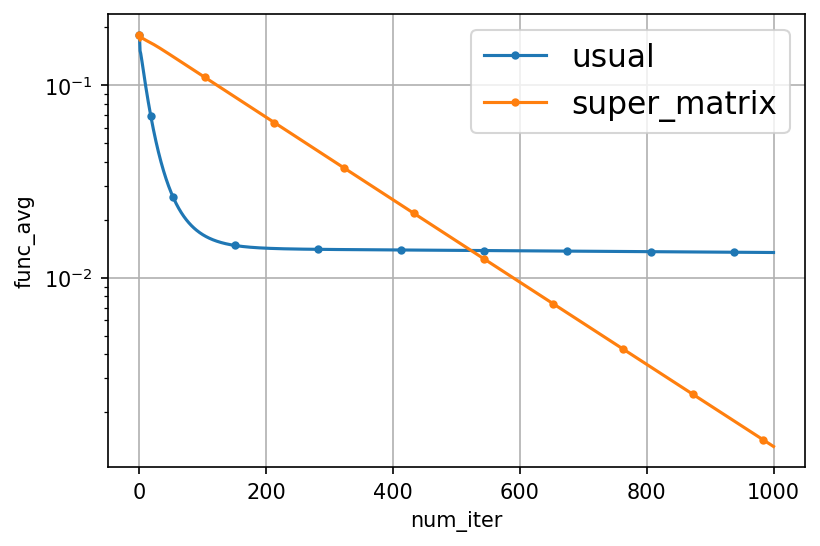

In [6]:
plot_experiment(logger_usual, logger_super, "func")